In [1]:
import numpy as np
def seqTrans(argument):
    switcher = {
        'A': 1,
        'T': 2,
        'G': 3,
        'C': 4,
        'N': np.random.randint(1,4)
    }
    return switcher.get(argument, "Invalid month")

def lineToArr(line):
    arr = np.array([])
    for a in line:
        v = seqTrans(a)    
        arr = np.append(arr,v)    
    return arr


import csv

l_arr = []
y =np.array([])
with open('NGS201811_Censored(updated).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print row
            line_count += 1
        else:            
            line_count += 1
            l_arr.append(lineToArr(row[0]))
            y = np.append(y,row[2])
            
m_data = np.asmatrix(l_arr)
y = y.astype('float32')
m_data = m_data.astype('float32')
#m_data = np.expand_dims(m_data, axis=2)
#m_data=m_data.transpose()
#y = y.reshape(1,len(y))
print y.shape, m_data.shape

(171427,) (171427, 33)


In [2]:
def rToM_old(r):
    m_new = np.zeros((r.size,r.size))
    for k in range(0,r.size):
        for j in range(0,r.size):
            if k == j:
                m_new[k,j] = r[k]
            elif r[k] ==1 and r[j] == 2 or (r[k] == 2 and r[j] == 1):
                m_new[k,j] = 5
            elif r[k] ==3 and r[j] == 2 or (r[k] == 2 and r[j] == 3):
                m_new[k,j] = 6
            elif r[k] ==3 and r[j] == 4 or (r[k] == 4 and r[j] == 3):
                m_new[k,j] = 7
    return m_new

def rToM(r):
    m_new = np.zeros((r.size,r.size))
    for k in range(0,r.size):
        for j in range(k+1,r.size):
            if k == j:
                m_new[k,j] = r[k]     
            elif r[k] ==1 and r[j] == 2 or (r[k] == 2 and r[j] == 1):
                m_new[k,j] = 5
            elif r[k] ==3 and r[j] == 2 or (r[k] == 2 and r[j] == 3):
                m_new[k,j] = 6
            elif r[k] ==3 and r[j] == 4 or (r[k] == 4 and r[j] == 3):
                m_new[k,j] = 7
    m = m_new.transpose()
    m = m + m_new
    m[np.diag_indices_from(m)] = r
    return m

nr,nc = m_data.shape
m_data_image = np.empty([nr,nc,nc], dtype = int) 
for i in range(nr):
    r = m_data[i,:]
    r = np.asarray(r)
    r = r.ravel()   
    m_new = rToM(r)
    m_data_image[i] = m_new
    
    

0.0


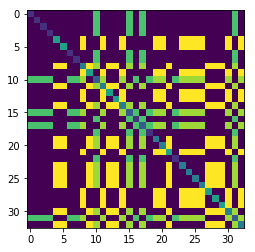

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
array = np.asmatrix(m_data_image[200]).astype(np.uint8) 
plt.imshow(array)
print y[200]

In [39]:
m_data = m_data_image
# Get the whole first file as trainning dataset, the other part as test
#  Equanlization of training dataset
Equalization = False
train_ratio = 0.7 
if Equalization:
    id_1 =  np.where(y==1)
    id_1 = id_1[0] 
    k = id_1.tolist()
    idx = np.random.randint(len(k),size=int(len(k)*train_ratio))
    x_train = m_data[idx,]
    y_train = y[idx,]
    print x_train.shape,y_train.shape
else:
    # No equalization of training dataset    
    import numpy
    a = numpy.arange(int(nr*train_ratio))
    numpy.random.shuffle(a)    
    idx = a#np.random.randint(nr, size=int(nr*train_ratio))
    #idx = range(171427)
    x_train = m_data[idx,]
    y_train = y[idx,]
    print x_train.shape,y_train.shape
    
    
from keras.utils import to_categorical

num_classes = 2

x_train = x_train.astype(int)
y_train = to_categorical(y_train,num_classes)
print y_train.shape

(119998, 33, 33) (119998,)
(119998, 2)


In [5]:
from keras import backend as K
import tensorflow as tf
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        	pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        	return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
#from focal_loss import focal_loss
model = Sequential()


#model.add(Flatten())
model.add(Conv2D(128, (3,3), activation='relu',input_shape=(33, 33, 1)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))
# compile the model 编译

model.compile(optimizer='adam', loss=[focal_loss(alpha=.25, gamma=2)], metrics=['acc'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model 打印模型信息
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 31, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 512)         1180160   
__________

In [7]:
x_train= x_train.reshape(x_train.shape[0],33,33,1)
# fit the model 拟合
import keras

BATCH_SIZE=200
EPOCHS = 50
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

history = model.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.01,
                      verbose=1)
#history = model.fit(x_train, y_train, epochs=50,verbose=1)
# evaluate the model 评估
#loss, accuracy = model.evaluate(x_train, labels, verbose=0)
#print('Accuracy: %f' % (accuracy*100))


--- Fit the model ---

Train on 118798 samples, validate on 1200 samples
Epoch 1/50
118798/118798 [==============================] - 66s 559us/step - loss: 23.5504 - acc: 0.8068 - val_loss: 15.9919 - val_acc: 0.8800
Epoch 2/50
118798/118798 [==============================] - 52s 435us/step - loss: 12.9016 - acc: 0.8999 - val_loss: 11.0332 - val_acc: 0.9067
Epoch 3/50
118798/118798 [==============================] - 54s 451us/step - loss: 9.6123 - acc: 0.9282 - val_loss: 8.6988 - val_acc: 0.9408
Epoch 4/50
118798/118798 [==============================] - 56s 470us/step - loss: 7.4255 - acc: 0.9466 - val_loss: 7.2115 - val_acc: 0.9567
Epoch 5/50
118798/118798 [==============================] - 50s 419us/step - loss: 5.7459 - acc: 0.9590 - val_loss: 6.6538 - val_acc: 0.9583
Epoch 6/50
118798/118798 [==============================] - 52s 441us/step - loss: 4.3752 - acc: 0.9701 - val_loss: 6.2688 - val_acc: 0.9617
Epoch 7/50
118798/118798 [==============================] - 59s 499us/step -

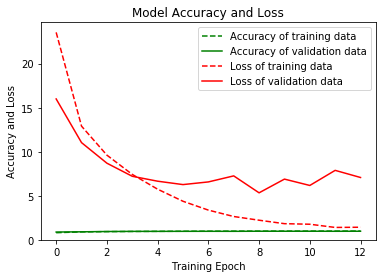

In [8]:
# summarize history for accuracy and loss
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [9]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [41]:
m_data = m_data.reshape(171427,33,33,1)
x_test=np.delete(m_data,idx,axis=0)

print x_test.shape

(51429, 33, 33, 1)



--- Check against test data ---

(51429, 33, 33, 1) (51429,)
51429/51429 [==============================] - 13s 244us/step

Accuracy on test data: 0.96

Loss on test data: 1.51

--- Confusion matrix for test data ---



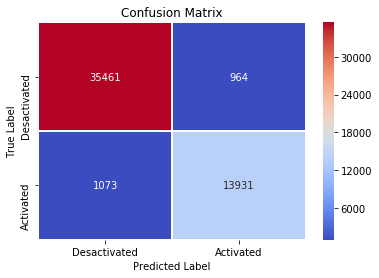


--- Classification report for test data ---

             precision    recall  f1-score   support

          0       0.97      0.97      0.97     36425
          1       0.94      0.93      0.93     15004

avg / total       0.96      0.96      0.96     51429



In [42]:
#%%

m_data = m_data.reshape(171427,33,33,1)


from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
LABELS = ["Desactivated",
          "Activated"]

print("\n--- Check against test data ---\n")

#idx = range(10)
x_test=np.delete(m_data,idx,axis=0)
y_test=np.delete(y,idx)

print x_test.shape, y_test.shape

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [11]:
print x_test.shape
print m_data.shape

(85184, 33, 33, 1)
(171427, 33, 33, 1)


In [12]:
import numpy as np
from keras.preprocessing.text import one_hot
def seqTrans(argument):
    switcher = {
        'A': 1,
        'T': 2,
        'G': 3,
        'C': 4,
        'N': np.random.randint(1,4)
    }
    return switcher.get(argument, "Invalid month")

def lineToArr(line):
    arr = np.array([])
    for a in line:
        v = seqTrans(a)    
        arr = np.append(arr,v)    
    return arr


import csv

l_arr = []
y =np.array([])

vocab_size = 64

#with open('NGS201811_Censored(updated).csv') as csv_file:
#    csv_reader = csv.reader(csv_file, delimiter=',')
#    line_count = 0
#    for row in csv_reader:
#        if line_count == 0:
#            #print row
#            line_count += 1
#        else:            
#            line_count += 1
#            s = row[0]
#            lw = [s[i:i+3] for i in range(0, len(s)-2, 1)]  #lw = [s[i:i+3] for i in range(0, len(s), 3)]            
#            encoded_docs = [one_hot(d, vocab_size) for d in lw]
#            arr_id = np.asarray(encoded_docs)            
#            l_arr.append(arr_id.ravel())
#            y = np.append(y,row[2])

with open('NGS201811_Censored(updated).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            #print row
            line_count += 1
        else:            
            line_count += 1
            s = row[0]
            lw = [s[i:i+3] for i in range(0, len(s)-2, 1)]  #lw = [s[i:i+3] for i in range(0, len(s), 3)]            
            encoded_docs = [one_hot(d, vocab_size) for d in lw]
            arr_id = np.asarray(encoded_docs)            
            l_arr.append(arr_id.ravel())
            y = np.append(y,row[2])            
            
m_data = np.asmatrix(l_arr)
y = y.astype('float32')
#m_data = m_data.astype('float32')
#m_data = np.expand_dims(m_data, axis=2)
#m_data=m_data.transpose()
#y = y.reshape(1,len(y))
print y.shape, m_data.shape

(171427,) (171427, 31)
